# Tutorial 1: The Canonical HANK Model & Fiscal Policy (no blanks)

NBER Heterogeneous-Agent Macro Workshop

Spring 2023

This notebook aims to provide a step-by-step tutorial on how to set up the canonical HANK model from scratch using `sequence-jacobian` and then proceeding to compute some simple impulse responses.

The first step is to import packages we'll need for this notebook.

In [1]:
import numpy as np  # numpy helps us perform linear algebra calculations
import matplotlib.pyplot as plt  # helps us plot
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc

Before we start, we'll define some basic model parameters we need below. We store them in the `calibration` dictionary:

In [2]:
calibration = {'eis': 0.5,  # EIS
               'rho_e': 0.9,  # Persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,  # Standard deviation of idiosyncratic productivity shocks
               'G': 0.2,  # Government spending
               'B': 0.8,  # Government debt
               'Y': 1.,  # Output
               'min_a': 0.,  # Minimum asset level on the grid
               'max_a': 1_000,  # Maximum asset level on the grid
               'n_a': 200,  # Number of asset grid points
               'n_e': 10}  # Number of productivity grid points

## Building the canonical HA Model

### Defining the `HetBlock`

First, we will set up the `HetBlock` that represents our heterogeneous household problem.

For the sake of clarity, we directly write these in the code block below, but since it's a really standard `Block`, we can also import it directly from within `sequence-jacobian` by calling `from sj.hetblocks.hh_sim import hh_init, hh`.

 - `hh_init` initializies the values for the backward iteration, which is `Va`, the derivative of the value function with respect to assets, defined over a joint grid of income and asset states. We always write the grids as (income state, asset state).
 - `hh` is a single backward step of the endogenous gridpoints method, covered in an earlier session.
 - the decorator `@sj.het` turns the subsequent function definition into a `HetBlock`. We'll have similar decorators below to define blocks.

In [3]:
# initialize
def hh_init(a_grid, z, r, eis):
    coh = (1 + r) * a_grid[np.newaxis, :] + z[:, np.newaxis]
    Va = (1 + r) * coh ** (-1 / eis)
    return Va

# backward step
@sj.het(exogenous='Pi',  # <-- this means our transition matrix will be fed into the model as Pi (use this for forward iteration)
        policy='a',  # <-- this means our endogenous state variable is a, defined over grid a_grid (we use this to check convergence)
        backward='Va',  # <-- this means we're iterating over variable Va, whose future value is Va_p (solver needs to know this to iterate!)
        backward_init=hh_init)
def hh(Va_p, a_grid, z, r, beta, eis):
    uc_nextgrid = beta * Va_p  # u'(c') on tomorrow's grid
    c_nextgrid = uc_nextgrid ** (-eis)  # c' on tomorrow's grid
    coh = (1 + r) * a_grid[np.newaxis, :] + z[:, np.newaxis]  # cash on hand on today's grid
    a = sj.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)  # this plots (c_next + a', a') pairs and computes policy a' from interpolation on coh
    sj.misc.setmin(a, a_grid[0])  # impose borrowing constraint
    c = coh - a  # back out consumption
    Va = (1 + r) * c ** (-1 / eis)  # V'(a)
    return Va, a, c

# forward iteration is done automatically!

We just created our first block! Let's check it out.

In [4]:
print(hh)
print('It has inputs: ' + str(hh.inputs))
print('It has outputs: ' + str(hh.outputs))

<HetBlock 'hh'>
It has inputs: ['a_grid', 'z', 'r', 'beta', 'eis', 'Pi']
It has outputs: ['A', 'C']


We see that some of these inputs are vectors, such as `a_grid` and `z`. We typically try to define them within the `HetBlock` itself. We can do so by attaching a `hetinput` function that constructs these inputs "in-house" so to speak.

A `hetinput` is a function, which takes either scalar- or vector-valued inputs that are generated from other upstream `hetinput`s, and yields vector-valued outputs that feed into its associated `HetBlock`.

- `make_grids` instantiates the productivity and assets grids:
    - productivity grid `e_grid` is from the Rouwenhorst method for discretizing AR(1) processes.
    - asset grid `a_grid` uses a non-uniform spacing concentrating grid points near the bottom, where policies exhibit the most curvature.

- `income` converts the productivity grid `e_grid` into the post-tax income grid `z`.

Note: in the `.markov_rouwenhorst` function, we normalize $\mathbb{E}[e] = 1$, which is consistent with the exogenous labor supply $N = 1$ in this model.

We define `hh_extended` as a `HetBlock` that has these additional `hetinputs`.

In [5]:
def make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a):
    e_grid, _, Pi = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    return e_grid, Pi, a_grid

def income(Z, e_grid):
    z = Z * e_grid
    return z

hh_extended = hh.add_hetinputs([make_grids, income])

Let's see what the new block does.

In [6]:
print(hh_extended)
print('It has inputs: ' + str(hh_extended.inputs))
print('It has outputs: ' + str(hh_extended.outputs))

<HetBlock 'hh' with hetinput 'make_grids_income'>
It has inputs: ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'Z']
It has outputs: ['A', 'C']


We see that the inputs changed: Now `a_grid` and `e_grid` are no longer inputs. Instead, `Z`, total after tax income, is among the inputs. In fact, `Z` will be the only input that will change in GE in our experiments below.

### Defining the `SimpleBlock`s

Next, we will specify two `SimpleBlock`s that will allow us to close our model: a fiscal policy (government) block and a market clearing block.

Here, we define the fiscal block in terms of government bonds `B`.

In [7]:
@sj.simple
def fiscal(B, r, G, Y):
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = Y - C - G
    return asset_mkt, goods_mkt

Now we can put these `Block`s together to create a model!

In [8]:
ha = sj.create_model([hh_extended, fiscal, mkt_clearing], name="Simple HA Model")

Let's see what kind of animal `ha` is.

In [9]:
print(ha)
print('It has inputs: ' + str(ha.inputs))
print('It has outputs: ' + str(ha.outputs))

<Model 'Simple HA Model'>
It has inputs: ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'B', 'G', 'Y']
It has outputs: ['A', 'C', 'T', 'Z', 'deficit', 'asset_mkt', 'goods_mkt']


A model is really a `CombinedBlock`, which, like our $H$ function in lecture, itself has inputs and outputs.

Many of the inputs are model parameters, such as `eis`, `beta`, `rho_e`, etc. But some are actually aggregates we want to solve ("unknowns") for or shock ("exogenous inputs"). One nice feature in SSJ is that we don't have to distinguish the two at this point. This gives us flexibility to shock whatever we want later on.

Some of the outputs are "targets", such as `goods_mkt` or `asset_mkt`. By Walras' law, it is sufficient to impose either `asset_mkt` or `goods_mkt`.

## Calibrating a steady state

To solve for a steady state, we need to specify the unknowns that we are calibrating to satisfy the targets of the model. We can omit one of them (`goods_mkt` in this case) for now by Walras' law. We will check its value afterward to ensure our model is correctly specified. If this test fails, we made a mistake when setting up the model.

Because we want to fix the steady state interest rate `r` at a pre-specified value, to satisfy 1) `asset_mkt`, we will calibrate `beta`.

We could try to find the steady state ourselves:

In [10]:
calibration['r'] = 0.03
calibration['beta'] = 0.85

ss = ha.steady_state(calibration)
ss['asset_mkt']

0.7495465526215805

Or we do this automatically, by solving for the `beta` that sets `asset_mkt` to zero.

In [11]:
unknowns_ss = {'beta': (0.75, 0.9)}  # provide bounds on beta for the solver
targets_ss = ['asset_mkt']  # set the ss target

ss = ha.solve_steady_state(calibration, unknowns_ss, targets_ss)

Now let's verify that Walras law holds

In [12]:
print(f"Goods market clearing: {ss['goods_mkt']}")

Goods market clearing: 2.929695375186725e-11


### Matching MPCs

One important lesson from today's classes was that MPC's are really important, more important than the wealth distribution itself to accurately capture the aggregate dynamics of heterogeneous-agent models. So could we try to match equilibrium MPCs here, too?

To do this, we need to compute MPCs, but those depend on the policy function `c` that lives within the `HetBlock` for now! We see this by checking `hh_extended`'s outputs:

In [13]:
print(hh_extended.outputs)

['A', 'C']


To compute MPCs, we can define a `hetoutput` function:

A `hetoutput` is a function, which takes scalar- and vector-valued inputs provided in the `calibration` or computed within the `HetBlock` it is attached to, and produces vector-valued outputs. A common use case for `hetoutput`s is to compute a quantity that is not necessary as a step in the backward iteration of the `HetBlock` itself but is useful as a target in the model DAG or as an output the user cares to inspect.

Other examples of `hetoutput` functions are functions that compute, e.g. moments of the wealth distribution.

In [14]:
def compute_weighted_mpc(c, a, a_grid, r, e_grid):
    """Approximate mpc out of wealth, with symmetric differences where possible, exactly setting mpc=1 for constrained agents."""
    mpc = np.empty_like(c)
    post_return = (1 + r) * a_grid
    mpc[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (post_return[2:] - post_return[:-2])
    mpc[:, 0] = (c[:, 1] - c[:, 0]) / (post_return[1] - post_return[0])
    mpc[:, -1] = (c[:, -1] - c[:, -2]) / (post_return[-1] - post_return[-2])
    mpc[a == a_grid[0]] = 1
    mpc = mpc * e_grid[:, np.newaxis]
    return mpc

hh_extended = hh_extended.add_hetoutputs([compute_weighted_mpc])

ha = sj.create_model([hh_extended, fiscal, mkt_clearing], name="Simple HA Model")

What did this do? Let's see how it affected `hh_extended`.

In [15]:
print(hh_extended.outputs)

['A', 'C', 'MPC']


Now we have an MPC variable as output! Let's check what it is in our current calibration by evaluating `hh_extended` at the `ss` dict.

In [16]:
hh_extended.steady_state(ss)['MPC']

0.24792226258418743

That's already very close, but let's say we want to match it perfectly. One way we can do so is by modifying `B`, the overall amount of liquidity, to hit it perfectly.

Why? Choosing `B` sets the amount of liquidity available to households to ensure themselves against their idiosyncratic risk. As the amount of liquidity in the economy goes down, the cross-sectional distribution of households shifts toward the constrained asset level, raising their MPCs.

In [17]:
unknowns_ss = {'beta': 0.8, 'B': 0.4}
targets_ss = {'asset_mkt': 0., 'MPC': 0.25}  # <-- with a dict rather than a list, we can specify specific targets for output variables

ss_mpc = ha.solve_steady_state(calibration, unknowns_ss, targets_ss)

In [18]:
print(f"To achieve an MPC of 0.25, we had to reduce the available gov't debt from {ss['B']} to {ss_mpc['B']}")

To achieve an MPC of 0.25, we had to reduce the available gov't debt from 0.8 to 0.7872002987188814


Let's proceed to computing transitional dynamics with this new steady state

In [19]:
ss = ss_mpc

Notice that `ss` here can be used to inspect the steady state we have computed. It works much like a `dict` in python.

In [20]:
ss['Z'], ss['T'], ss['G'], ss['A']

(0.7763839910384335, 0.22361600896156653, 0.2, 0.7872002987181738)

One fun thing you can do here is plot the wealth distribution, which is stored in `ss.internals`.

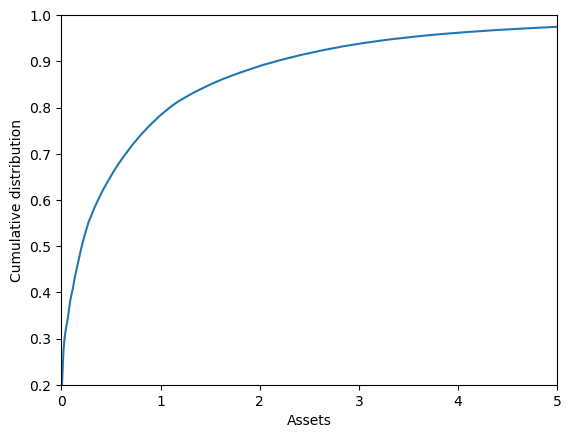

In [21]:
D = ss.internals['hh']['D'].sum(axis=0)
a_grid = ss.internals['hh']['a_grid']
plt.plot(a_grid, D.cumsum())
plt.ylim([0.2, 1])
plt.xlim([0, 5])
plt.xlabel('Assets')
plt.ylabel('Cumulative distribution')
plt.show()

## Transitional dynamics

Now that we have a steady state, let's compute some simple impulse responses

First, we will look at the response of output to a fully tax-financed increase in government spending of 1% of GDP, with persistence $\rho_G = 0.8$

In [22]:
T = 300  # <-- the length of the IRF
rho_G = 0.8
dG = 0.01 * rho_G ** np.arange(T)
shocks = {'G': dG}

What are the unknowns and targets we should specify to solve for this IRF? Let's investigate inputs and outputs of `ha` to figure this out.

In [23]:
print(ha.inputs)
print(ha.outputs)

['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'B', 'G', 'Y']
['A', 'C', 'MPC', 'T', 'Z', 'deficit', 'asset_mkt', 'goods_mkt']


The only unknown is `Y` here. We have two `target`s, but only need one, so let's use `asset_mkt` for now. (`goods_mkt` is similar.)

To do this, we call the `.solve_impulse_linear` method on the `ha` model object, providing as input arguments: `ss`, the list of unknowns, the list of targets, and the dict of shocks. You can inspect the contents of the returned `ImpulseDict` object, by indexing into it as you would a `dict` object.

In [24]:
unknowns_td = ['Y']
targets_td = ['asset_mkt']

irfs = ha.solve_impulse_linear(ss, unknowns_td, targets_td, shocks)

Let's see what we got. First, let's just look at the numbers.

In [25]:
irfs['Y'][:10]

array([0.01      , 0.008     , 0.0064    , 0.00512   , 0.004096  ,
       0.0032768 , 0.00262144, 0.00209715, 0.00167772, 0.00134218])

Those are the first few entries of our `Y` response. Let's plot it!

To do so, we use a predefined simple plotting function.

In [26]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

Now we're ready to plot IRFs:

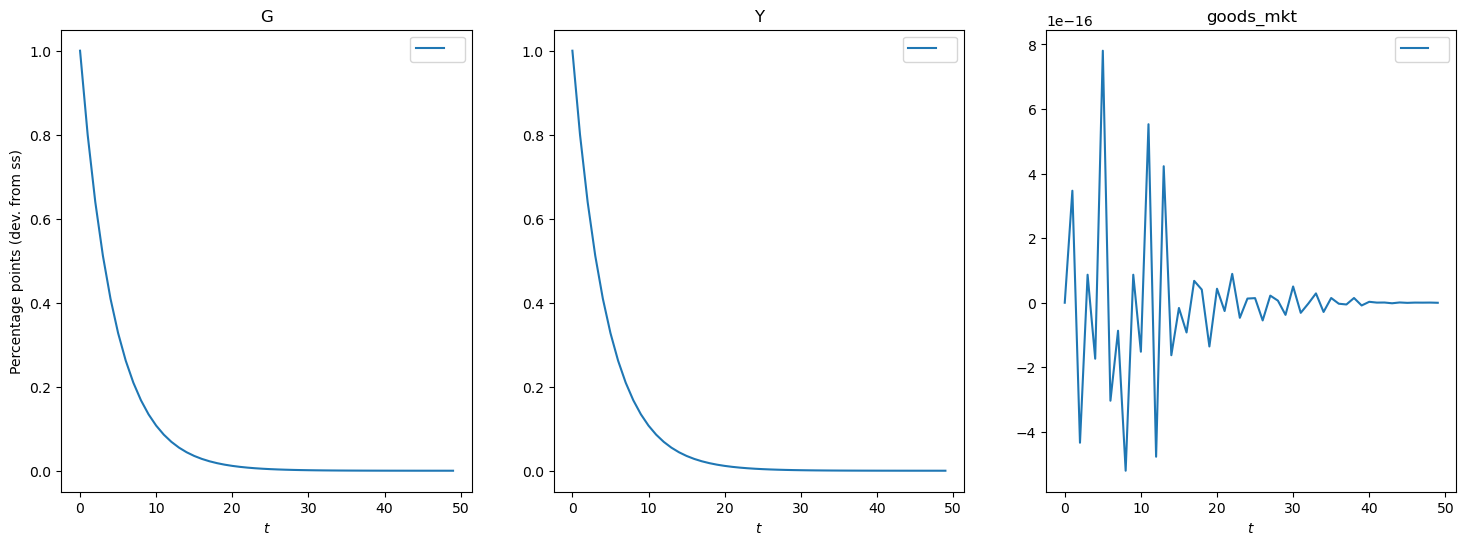

In [27]:
show_irfs([irfs], ['G', 'Y', 'goods_mkt'])

What if we want to make the increase in `G` entirely debt financed initially?

This means we need to feed in a simultaneous shock to `B`, that initially increases by the same amount as `G`.

In [28]:
rho_B = 0.9
# dB = dG[0] * rho_B ** np.arange(T)
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB}

irfs_B = ha.solve_impulse_linear(ss, unknowns_td, targets_td, shocks_B)

Let's compare IRFs across the two specifications.

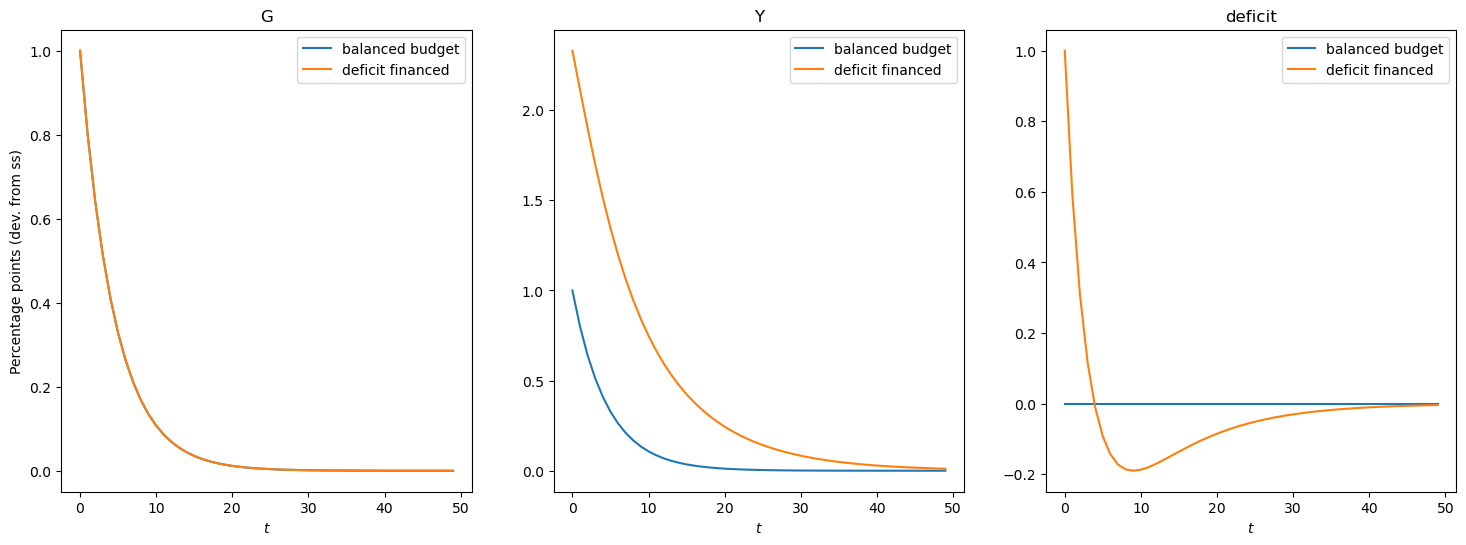

In [29]:
show_irfs([irfs, irfs_B], ['G', 'Y', 'deficit'], labels=["balanced budget", "deficit financed"])

That's interesting! The output effect is stronger with deficit financed spending. Why? Let's look at consumption

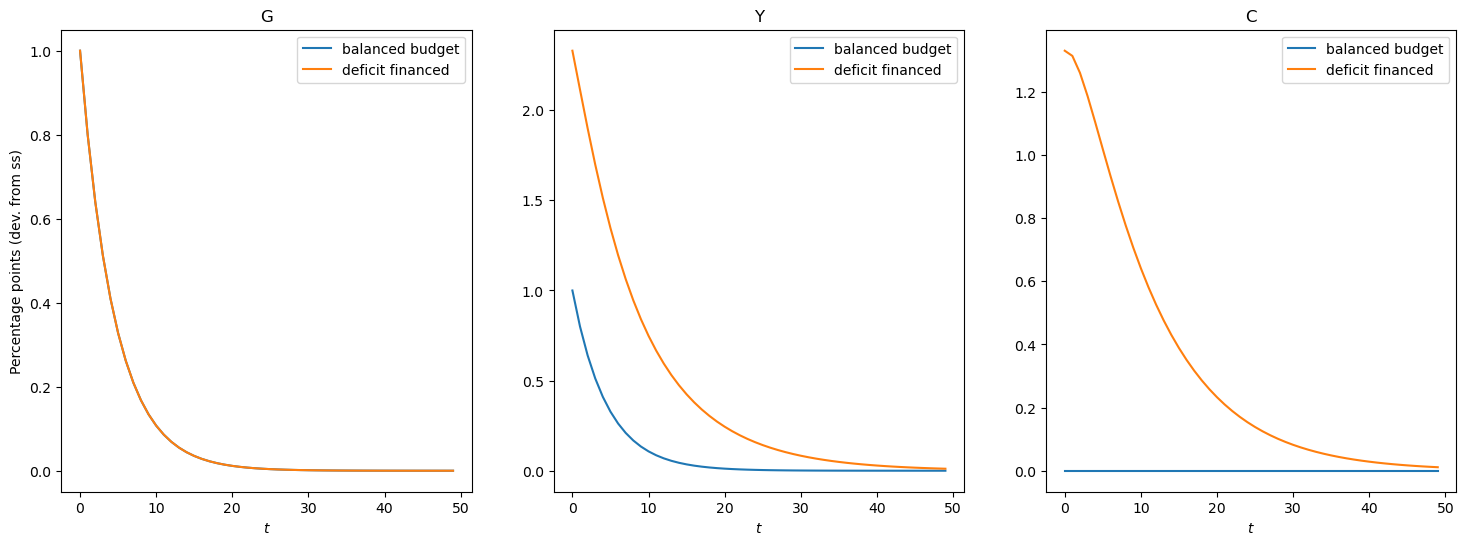

In [30]:
show_irfs([irfs, irfs_B], ['G', 'Y', 'C'], labels=["balanced budget", "deficit financed"], figsize=(18,6))

... because there was no effect on consumption from a balanced budget spending shock.

## Comparison with nonlinear impulse response

Here we compute the same shock nonlinearly, to see how it differs.

Solving Simple HA Model for ['Y'] to hit ['asset_mkt']
On iteration 0
   max error for asset_mkt is 2.41E-02
On iteration 1
   max error for asset_mkt is 7.21E-05
On iteration 2
   max error for asset_mkt is 5.03E-07
On iteration 3
   max error for asset_mkt is 3.33E-09


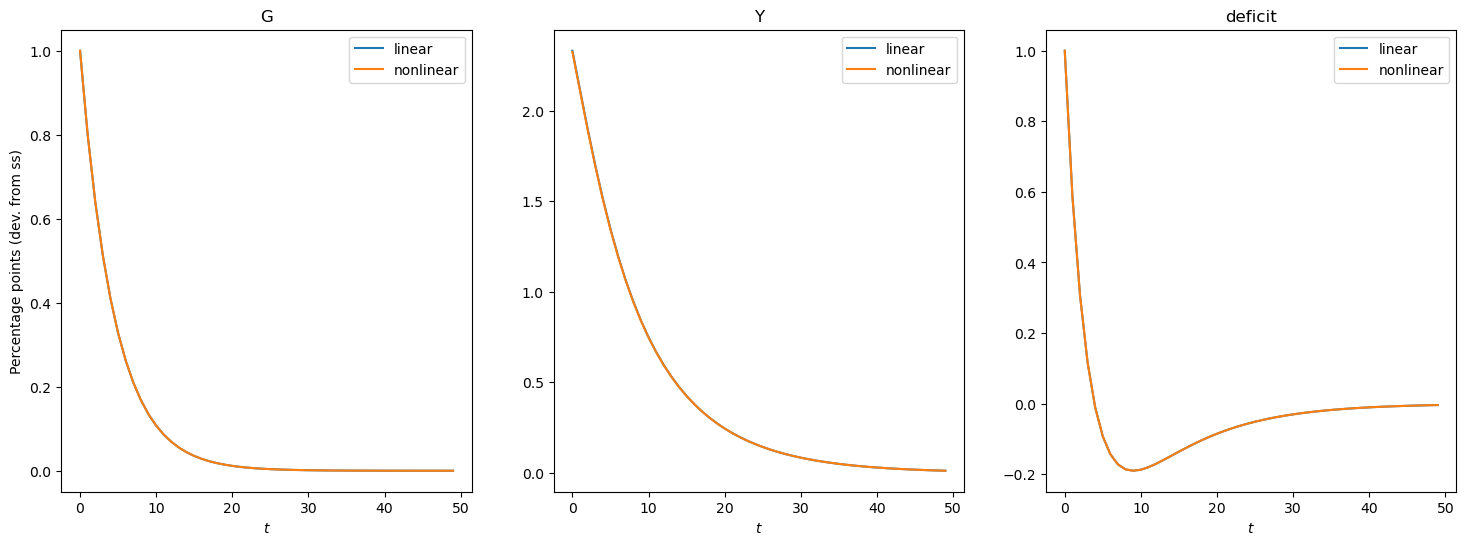

In [31]:
irfs_B_nonlinear = ha.solve_impulse_nonlinear(ss, unknowns_td, targets_td, shocks_B)
show_irfs([irfs_B, irfs_B_nonlinear], ['G', 'Y', 'deficit'], labels=["linear", "nonlinear"])

## Model with Taylor rule

Here we add a Phillips curve and a Taylor rule to the model.

In [32]:
@sj.simple
def nkpc(pi, Y, C, theta_w, vphi, frisch, markup_ss, eis, beta):
    kappa_w = (1 - theta_w) * (1 - beta * theta_w)/theta_w
    piwres = kappa_w * (vphi * (Y)**(1/frisch) - 1/markup_ss * C**(-1/eis)) + beta * pi(1) - pi
    return piwres


@sj.simple
def monetary_taylor(pi, ishock, rss, phi_pi):
    i = rss + phi_pi * pi + ishock
    r_ante = i - pi(1)
    return r_ante

@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

ha_taylor = sj.create_model([monetary_taylor, ex_post_rate, fiscal, hh_extended, mkt_clearing, nkpc], name="Simple HA Model with Taylor")

We calibrate the model just like before, but now need to include `piwres` as additional target, and the labor disutility parameter `vphi` as additional unknown.

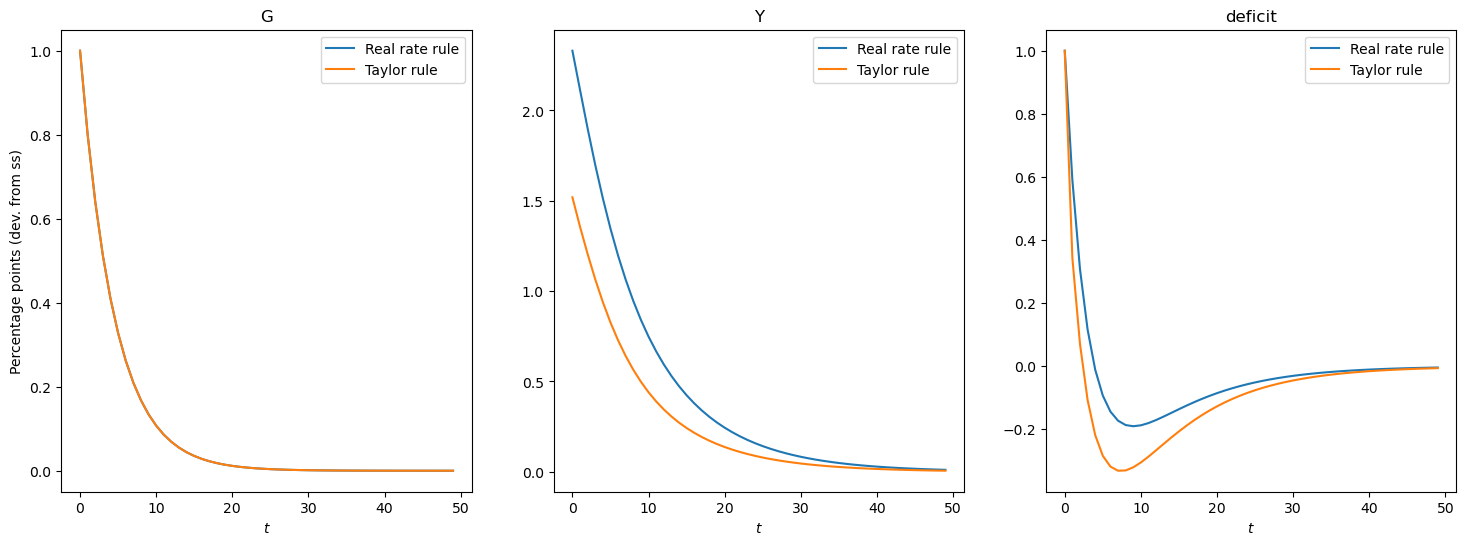

In [33]:
calibration.update({'pi':0, 'theta_w': 0.9, 'vphi':1, 'frisch':1, 'markup_ss':1, 'ishock': 0, 'rss': calibration['r'], 'phi_pi':1.5})

ss_taylor = ha_taylor.solve_steady_state(calibration, unknowns={'vphi': 1, 'beta': ss['beta']}, targets=['piwres', 'asset_mkt'])

irfs_taylor = ha_taylor.solve_impulse_linear(ss_taylor, ['pi', 'Y'], ['asset_mkt', 'piwres'], shocks_B)

show_irfs([irfs_B, irfs_taylor], ['G', 'Y', 'deficit'], labels=["Real rate rule", "Taylor rule"])

## Comparisons with RA and TA

Great, so we solved and understood our first HA model together!

Next, let's try to compare the propagation in HA with that in RA and TA models. To do so, we write `SimpleBlock`s that define the household problems for the representative and two-agent versions of the simple heterogeneous agent model we implemented above. What's nice is that we won't have to rewrite any other block!

We begin with the RA model. Here, we notice that the propagation is entirely determined by the Euler equation, which is recursive, so we'll have to handle that with a `SolvedBlock`.

In [34]:
@sj.solved(unknowns={'C': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, r):
    euler = (beta * (1 + r(+1)))**(-eis) * C(+1) - C
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    MPC = 0
    return euler, budget_constraint, MPC

ra = sj.create_model([hh_ra, fiscal, mkt_clearing], name="Representative agent model")

One big problem we notice here already: When $\beta = 1/(1+r)$, neither `C` nor `A` are determined! This is because the model has an infinitely elastic steady state savings supply curve.

So in the steady state, we'll have to solve for `C` and `A` directly.

We do something similar for the TA model.

In [35]:
@sj.solved(unknowns={'C_RA': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # , solver="broyden_custom")
def hh_ta(C_RA, A, Z, eis, beta, r, lam):
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA      # consumption of infinitely lived household
    C_H2M = Z   # computes consumption of an hand to mouth agent
    C = (1 - lam) * C_RA + lam * C_H2M
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    MPC = 0
    return euler, budget_constraint, C_H2M, C, MPC

ta = sj.create_model([hh_ta, fiscal, mkt_clearing], name="Two agent model")

We redefine `beta` in the calibration, and match the same `B` that we had in the HA model. Finally we pin down `C`  and `A`  to be consistent with the budget constraint and asset market clearing. Using the `dissolve` keyword argument turns the `SolvedBlock`s into `SimpleBlock`s for the purpose of steady state evaluation, i.e. to "promote" `C`, `A` from being unknowns at their individual block level to the model level.

In [36]:
calibration_ra = calibration.copy()
calibration_ra['beta'] = 1 / (1 + calibration_ra['r'])
calibration_ra['B'] = ss['B']

unknowns_ra_ss = {'C': 1., 'A': 0.8}
targets_ra_ss = {'budget_constraint': 0., 'asset_mkt': 0.}

ss_ra = ra.solve_steady_state(calibration_ra, unknowns_ra_ss, targets_ra_ss, dissolve=['hh_ra'])

In [37]:
calibration_ta = calibration_ra.copy()
calibration_ta['lam'] = 0.25
unknowns_ta_ss = {'C_RA': 1., 'A': 0.8}

ss_ta = ta.solve_steady_state(calibration_ta, unknowns_ta_ss, targets_ra_ss, dissolve=['hh_ta'])

First we will plot the impulse response to the same government spending shock that we used above for the HA model to ensure that the balanced budget responses are indeed the same across RA, TA, HA

In [38]:
irfs_ra = ra.solve_impulse_linear(ss_ra, unknowns_td, targets_td, shocks_B)
irfs_ta = ta.solve_impulse_linear(ss_ta, unknowns_td, targets_td, shocks_B)

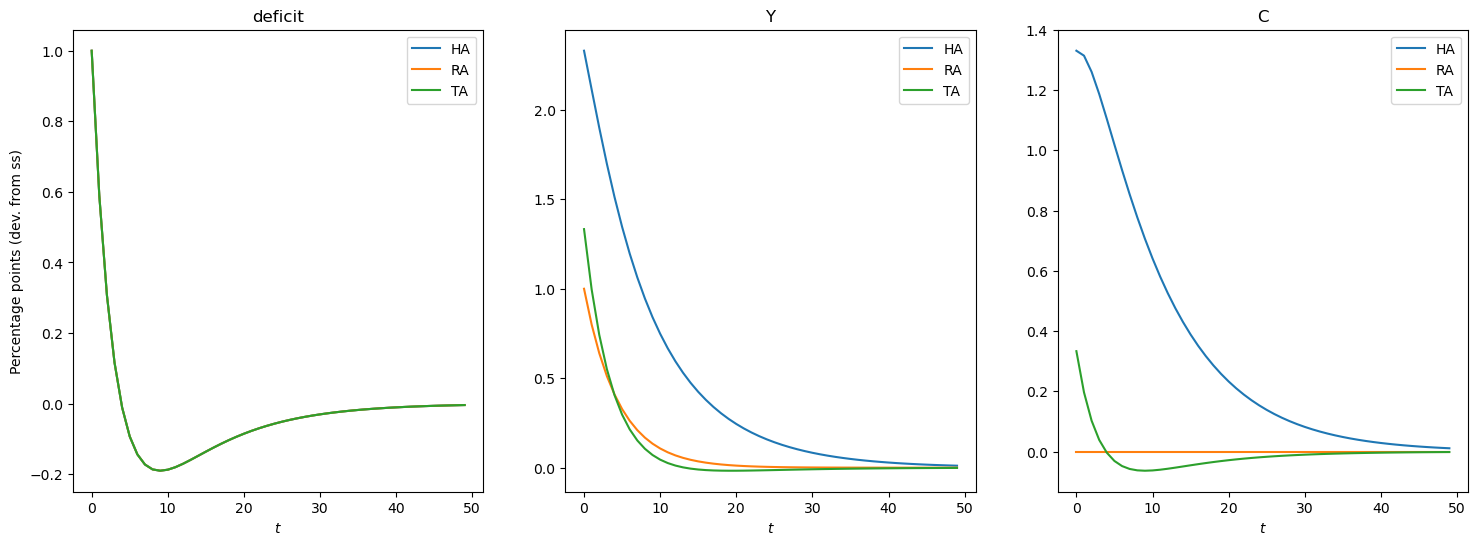

In [39]:
show_irfs([irfs_B, irfs_ra, irfs_ta], variables=['deficit', 'Y', 'C'], labels=['HA', 'RA', 'TA'])

Awesome! So we see that the HA model generates a large positive consumption response, much larger than the TA model. This is because the HA model generates higher iMPCs off the diagonal.

## Exercises

### Exercise 1: Sketch the DAG

Sketch the DAG that underlies the `ha` model.

### Exercise 2: Other shocks in the canonical HANK model

Feed in a negative 1% real interest rate shock into the model. This is an accommodative monetary policy shock. What happens in the three models? How is the MPC affected by monetary polic?

Do the same for other shocks:
 - shocks to `beta`?
 - shocks to risk aversion (negative shocks to `eis`)? This only makes sense in the HA model.
 - shocks to idiosyncratic risk (`sd_e`)? This only makes sense in the HA model.

### Exercise 3: Direct and indirect effects in monetary policy transmission

Consider our accommodative monetary policy shock from exercise 1. Focus on the household side. Can you use the equilibrium paths of `r` and `Z` to decompose how important each channel is in monetary transmission?
_(Hint: You can use `hh.impulse_linear` to simulate individual blocks)_

# Fiscal Consolidation

## 1) We want deficit to decrease and change Government spending

In [40]:
alpha = 0.1
@sj.simple
def fiscal_consolidation(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B # total tax burden
    # Fiscal rule reduce deficit by alpha each period as in Auclert et al (Micro Jumps and Macro Humps)
    T = alpha*(B(-1) - ss['B']) + ss['T']
    Z = Y - T   
    deficit = G - T
    
    return T, Z, deficit

In [41]:
ha_consolidation = sj.create_model([hh_extended, fiscal_consolidation, mkt_clearing], name="Simple HA Model with Fiscal Rule")

In [43]:
unknowns_td = ['Y']
targets_td = ['asset_mkt']

irfs_consolidation = ha_consolidation.solve_impulse_linear(ss, unknowns_td, targets_td, shocks)
irfs_B_consolidation = ha_consolidation.solve_impulse_linear(ss, unknowns_td, targets_td, shocks_B)

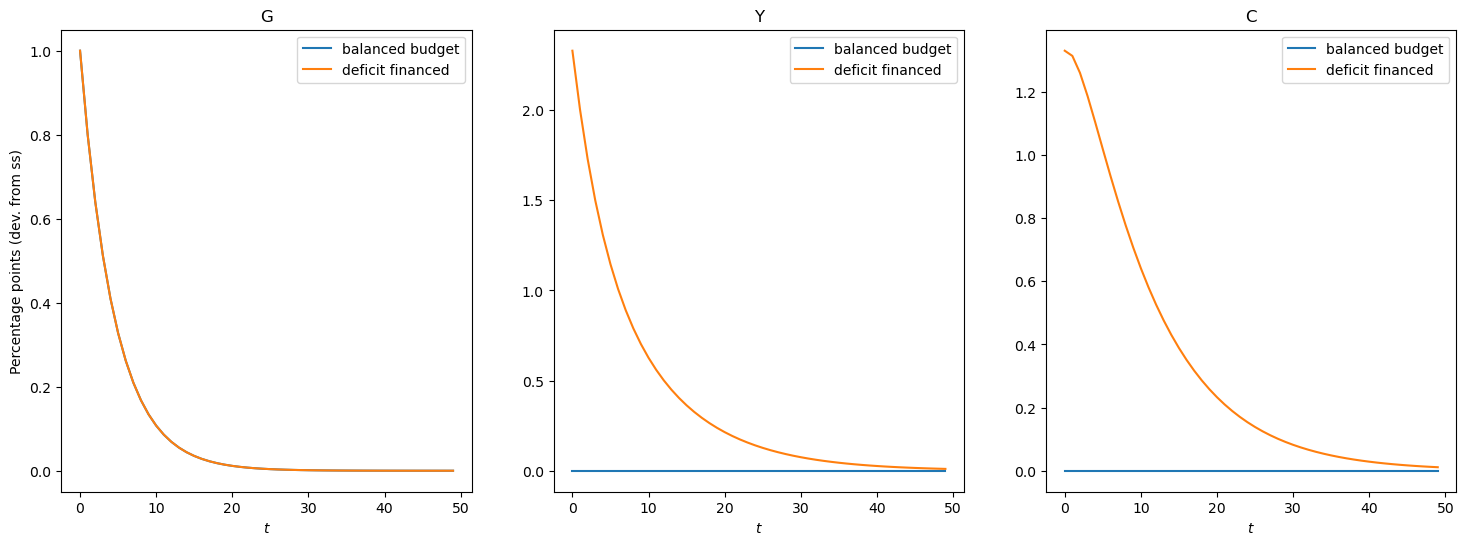

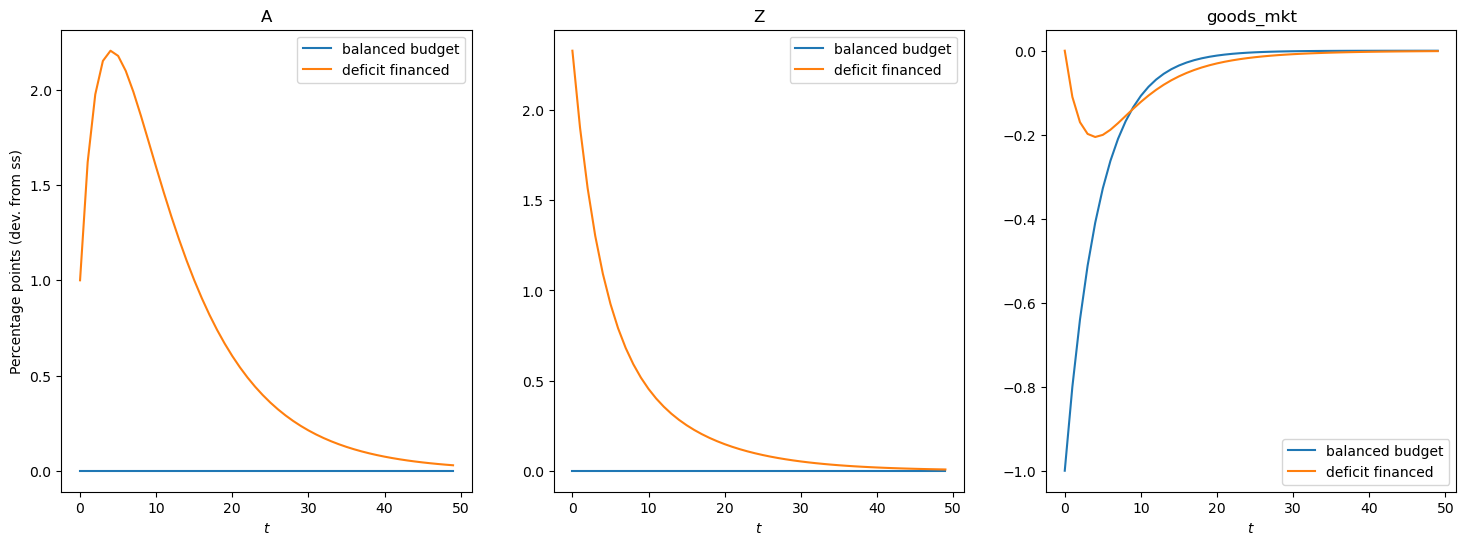

In [46]:
show_irfs([irfs_consolidation, irfs_B_consolidation], ['G', 'Y', 'C'], labels=["balanced budget", "deficit financed"], figsize=(18,6))
show_irfs([irfs_consolidation, irfs_B_consolidation], ['A', 'Z', 'goods_mkt'], labels=["balanced budget", "deficit financed"], figsize=(18,6))

In [42]:
stop

NameError: name 'stop' is not defined

In [ ]:
hh_extended.steady_state(ss)

<SteadyStateDict: ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'Z', 'A', 'C', 'MPC'], internals=['hh']>

In [ ]:
alpha = 0.1
@sj.simple
def fiscal_consolidation(B, r, T, Y): 
    #T = (1 + r) * B(-1) + G - B # total tax burden
    # Fiscal rule reduce deficit by alpha each period as in Auclert et al (Micro Jumps and Macro Humps)
    Fiscal_Debt = (1 + r) * B(-1) + ss['G'] - B
    # T = alpha*(B(-1) - B_ss) + T_ss
    #T = alpha*(B - B_ss) #+ T_ss
    # T = alpha *(Fiscal_Debt - B_ss)
    Z = Y - T  
    deficit = Fiscal_Debt - T
    
    return Z, deficit

@sj.simple
def mkt_clearing_consolidation(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

In [ ]:
ha_consolidation = sj.create_model([hh_extended, fiscal_consolidation, mkt_clearing_consolidation], name="Simple HA Model")

In [ ]:
MIT_persistence = 0.8
# Shock Taxes
T_std = +.01
dT_MIT =  T_std * MIT_persistence**np.arange(T)

# Government spending shock reduces deficit
# dB_MIT = np.cumsum(dG_MIT) * MIT_persistence ** np.arange(T)

dG_MIT = np.zeros(T)
# dT_MIT = np.zeros(T)
shocks_T_MIT = {'T': dT_MIT, 'G': dG_MIT}

In [ ]:
unknowns_td = ['Y']
targets_td = ['asset_mkt']

irfs_consolidation = ha_consolidation.solve_impulse_linear(ss, unknowns_td, targets_td, shocks_T_MIT)

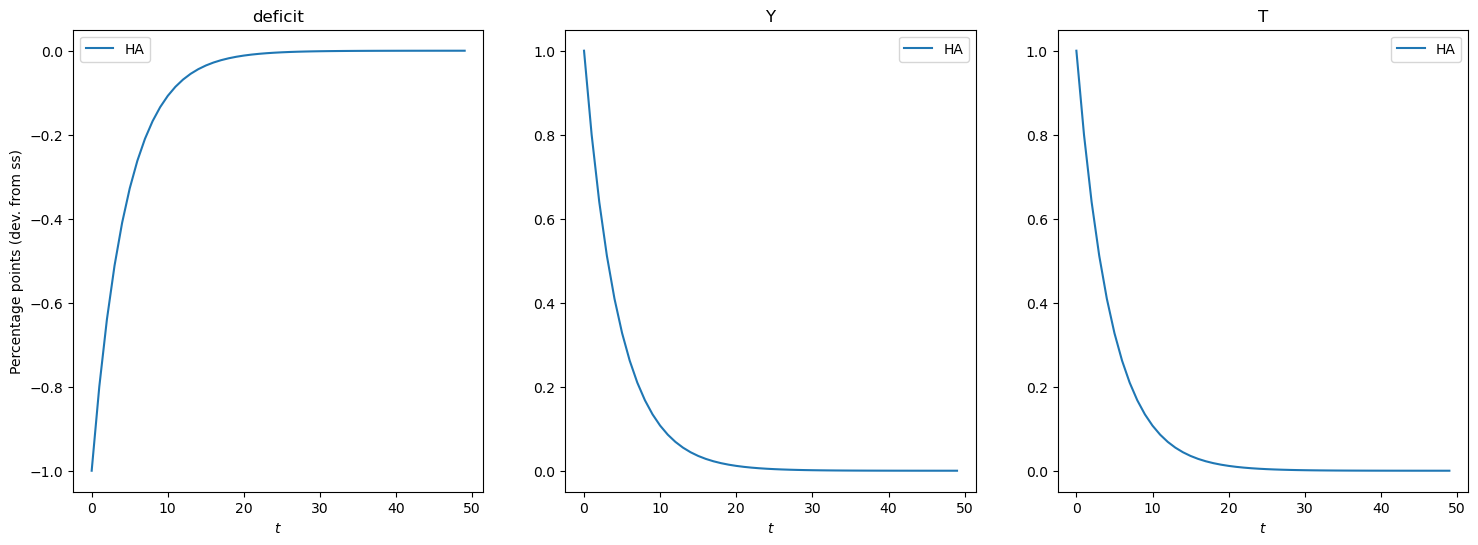

In [ ]:
show_irfs([irfs_consolidation], variables=['deficit', 'Y', 'T'], labels=['HA'])

In [ ]:
sj.drawdag(ha_consolidation, ha_consolidation.inputs, unknowns_td, targets_td)

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\sequence_jacobian\utilities\drawdag.py:98: UserWarning: 
Attempted to use `drawdag` when the package `graphviz` has not yet been installed. 
DAG visualization tools, i.e. drawdag, will not produce any figures unless this dependency has been installed. 
If you want to install, try typing 'conda install -c conda-forge python-graphviz' at the terminal,
or see README for more instructions. Once installed, re-load sequence-jacobian to produce DAG figures.


In [ ]:
!pip install python-graphviz

ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


In [ ]:
ha_consolidation.inputs

OrderedSet(['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'B', 'T', 'Y', 'G'])

In [ ]:
vars(ha_consolidation)

{'M': Bijection({}),
 'steady_state_options': {},
 'impulse_nonlinear_options': {},
 'impulse_linear_options': {},
 'jacobian_options': {},
 'partial_jacobians_options': {},
 'blocks': [<SimpleBlock 'fiscal_consolidation'>,
  <HetBlock 'hh' with hetinput 'make_grids_income' and with hetoutput `compute_weighted_mpc'>,
  <SimpleBlock 'mkt_clearing_consolidation'>],
 'inmap': {'r': OrderedSet([1, 0]),
  'beta': OrderedSet([1]),
  'eis': OrderedSet([1]),
  'rho_e': OrderedSet([1]),
  'sd_e': OrderedSet([1]),
  'n_e': OrderedSet([1]),
  'min_a': OrderedSet([1]),
  'max_a': OrderedSet([1]),
  'n_a': OrderedSet([1]),
  'Z': OrderedSet([1]),
  'B': OrderedSet([0, 2]),
  'T': OrderedSet([0]),
  'Y': OrderedSet([0, 2]),
  'A': OrderedSet([2]),
  'C': OrderedSet([2]),
  'G': OrderedSet([2])},
 'outmap': {'A': 1,
  'C': 1,
  'MPC': 1,
  'Z': 0,
  'deficit': 0,
  'asset_mkt': 2,
  'goods_mkt': 2},
 'adj': [OrderedSet([1]), OrderedSet([2]), OrderedSet([])],
 'revadj': [OrderedSet([]), OrderedSet([0]